# μA78L05 Analysis and Simulation

By Shuo Chen (chenshuo_at_chenshuo.com)

Latest notebook: https://github.com/chenshuo/notes/blob/master/notebooks/UA78L05.ipynb

Comments and discussions: https://github.com/chenshuo/notes/discussions

In [1]:
%matplotlib inline

from math import exp, log, log10

# NgSpice
import ngspyce as ng

import numpy as np
from matplotlib import pyplot as plt

def para(r1, r2):
    return (r1*r2) / (r1 + r2)

def print_op(print_base_current=True, print_emitter_current=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ib]' in k and not print_base_current:
            continue
        if '[ie]' in k and not print_emitter_current:
            continue

        print('%10s = %8.2f uA' % (k, 1e6*op[k][0]))
    else:
        print('%10s = %8.2f mV' % (k, 1e3*op[k][0]))

In [2]:
# Circuitikz
# pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

## Schematic

There are multiple versions of 78L05, I found at least three:

1. Signetics μA78L05 = TI's [UA78L05](https://www.ti.com/lit/ds/symlink/ua78l.pdf) nowadays. It is the circuit analyzed here.
2. Fairchild announced its μA78L05 in 1974 _Voltage Regulator Applications Handbook_, which employs a different design. It's the same as ST's [L78L05](https://www.st.com/resource/en/datasheet/l78l.pdf)
3. National [LM78L05](https://www.ti.com/lit/ds/symlink/lm78l.pdf) seems doesn't use bandgap reference, but a Zener diode.

TI makes both μA78L05 and LM78L05, they are drop-in replacement of each other, but their internal schematics are completely different. Same happens on TI's LM7805, LM340 and μA7805. 

> "However, it turns out that the part numbers are really just marketing, and have little to do with what's inside the chip."  https://www.righto.com/2014/09/reverse-engineering-counterfeit-7805.html

The internal schematic below is from [_1977 Signetics Analog Data Manual_](http://www.bitsavers.org/components/signetics/_dataBooks/1977_Signetics_Analog_Data_Manual.pdf) p.160.

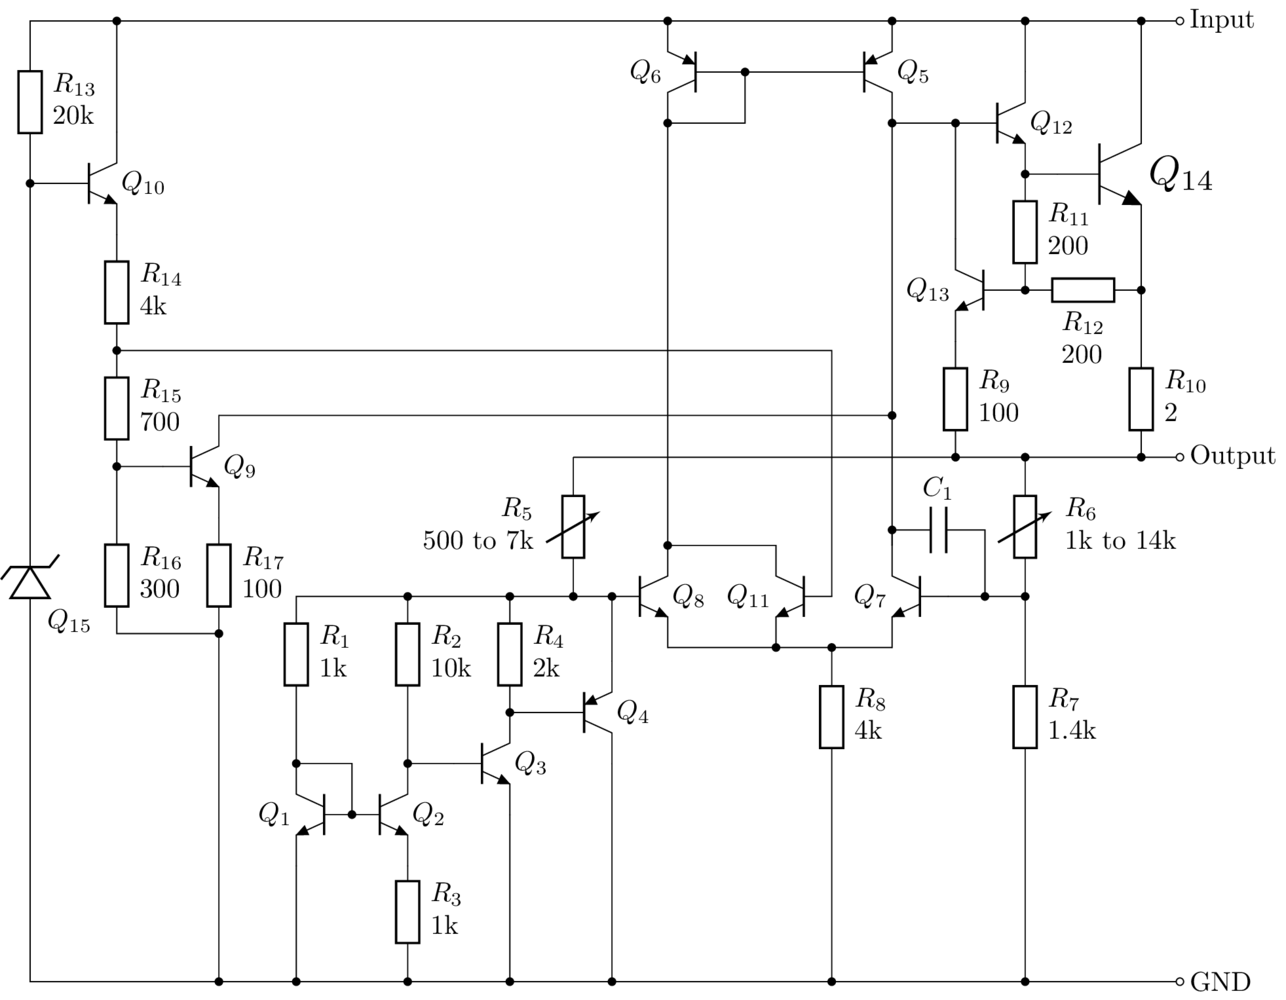

The resistance values are of course very important. However, the numbering of transistors also reveal some information. IMO, it probably reflects how the circuit was designed. 
1. First, $Q_1\dots Q_4$ form the bandgap reference. Btw, $Q_4$ is off in normal operation.
2. Then,  $Q_5\dots Q_8$ made the error amplifier.
3. $Q_{12}$ and $Q_{14}$ are the output stage, the pass transistor.

Those 10 transistors construct the DC path, the remaining are auxiliary circuits.

5. $Q_{13}$ is current limiting, $R_{10}$ is current sense resistor.
6. $Q_{10}$ and $Q_{11}$, with zener diode $Q_{15}$ are start-up circuit.
7. $Q_{9} and zener diode $Q_{15}$ are overheat protection

### Simplified

If we omit all protection and start-up circuits, the DC path is clean and straight forward to understand.

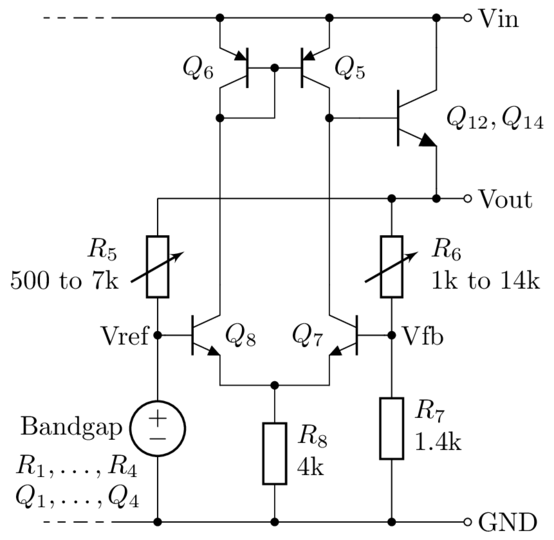

**Estimate the reference voltage**

* $R_6$ sets the output voltage, Vfb = Vref when balanced.
* μA78Lxx series has maximum output voltage of 15V, so I guess $R_6=14$kΩ when Vout=15V.
* Vfb = $\dfrac{1.4}{1.4+14}\times 15 = 15 / 11 = 1.364$V
* Then Vref = 1.364V


### Further simplified

The DC path is a basic series regulator made of a reference, an op amp, and a pass transistor, as shown below.

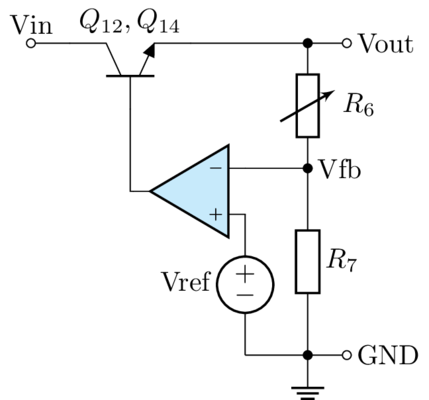

## Bandgap voltage reference

The bandgap reference made of $Q_1\dots Q_4$ is driven by current through $R_5$,
when Vout is set to 5V, $R_5$ should ensure the bandgap have a good tempco.

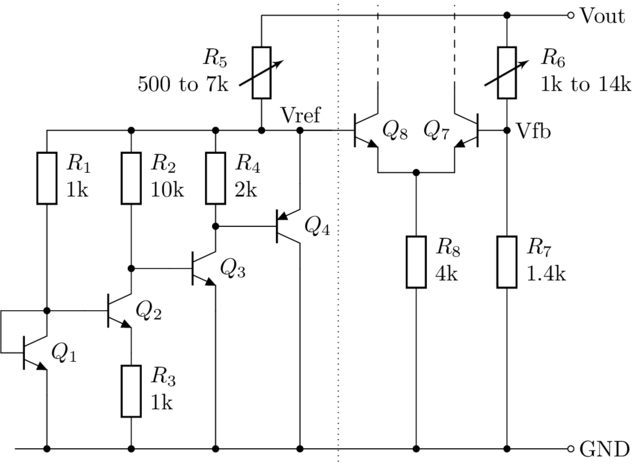

We now simulate the circuit on the left side of the dotted line.

Print the DC operating point of following SPICE netlist

```SPICE
  * Bandgap reference of UA78Lxx
  V1 out 0 5V
  R5 out q8b 4k
  R1 q8b q1b 1k
  R2 q8b q3b 10k
  Q1 q1b q1b 0 NPN
  Q2 q3b q1b r3 NPN
  R3 r3 0 1k
  R4 q8b q4b 2k
  Q3 q4b q3b 0 NPN
  Q4 0 q4b q8b PNP
  
  .model NPN NPN(BF=120 Cje=1p Cjc=2p Rb=40 VAF=80 VAR=50 KF=3.2e-16 AF=1)
  .model PNP PNP(BF=60 Cje=1p Cjc=3p Rb=80 VAF=70 VAR=40)
  .options savecurrents
```


In [12]:
ng.circ('''
  V1 out 0 5V
  R5 out q8b 4k
  R1 q8b q1b 1k
  R2 q8b q3b 10k
  Q1 q1b q1b 0 NPN
  Q2 q3b q1b r3 NPN
  R3 r3 0 1k
  R4 q8b q4b 2k
  Q3 q4b q3b 0 NPN
  Q4 0 q4b q8b PNP
  .model NPN NPN(BF=120 Cje=1p Cjc=2p Rb=40 VAF=80 VAR=50 KF=3.2e-16 AF=1)
  .model PNP PNP(BF=60 Cje=1p Cjc=3p Rb=80 VAF=70 VAR=40)
  .options savecurrents
''')

print_op(False, True)

   @q1[ic] =   585.75 uA
   @q1[ie] =  -590.71 uA
   @q2[ic] =    59.05 uA
   @q2[ie] =   -59.55 uA
   @q3[ic] =   259.45 uA
   @q3[ie] =  -261.64 uA
   @q4[ic] =    -0.05 uA
   @q4[ie] =     0.05 uA
    @r1[i] =   591.21 uA
    @r2[i] =    61.24 uA
    @r3[i] =    59.55 uA
    @r4[i] =   259.45 uA
    @r5[i] =   911.95 uA
       out =  5000.00 mV
       q1b =   760.99 mV
       q3b =   739.78 mV
       q4b =   833.31 mV
       q8b =  1352.20 mV
        r3 =    59.55 mV
 v1#branch =  -911.95 uA


The results is shown in following schematic.

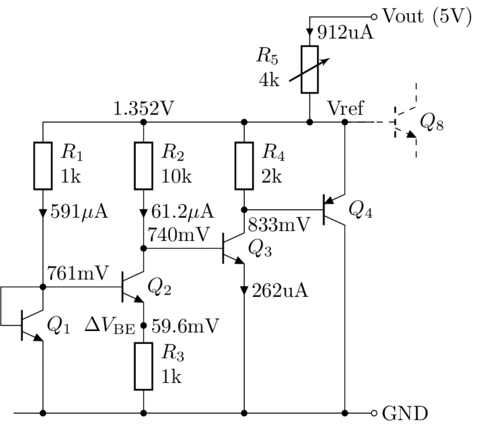

$R_5$ sets the current of bandgap circuit, and affects the temperature curve.

Try finding the best $R_5$.

R5 = 3500, Iq = 1036.6 uA, Vref@27C = 1.372 V, delta =   10.14 mV
R5 = 3600, Iq = 1008.6 uA, Vref@27C = 1.369 V, delta =    6.70 mV
R5 = 3700, Iq =  982.3 uA, Vref@27C = 1.366 V, delta =    3.43 mV
R5 = 3800, Iq =  957.6 uA, Vref@27C = 1.361 V, delta =    0.98 mV
R5 = 3900, Iq =  934.2 uA, Vref@27C = 1.357 V, delta =   -0.78 mV
R5 = 4000, Iq =  912.0 uA, Vref@27C = 1.352 V, delta =   -2.33 mV
R5 = 4100, Iq =  890.8 uA, Vref@27C = 1.348 V, delta =   -3.87 mV
R5 = 4200, Iq =  870.6 uA, Vref@27C = 1.343 V, delta =   -5.47 mV
R5 = 4300, Iq =  851.4 uA, Vref@27C = 1.339 V, delta =   -7.13 mV
R5 = 4400, Iq =  833.0 uA, Vref@27C = 1.335 V, delta =   -8.86 mV


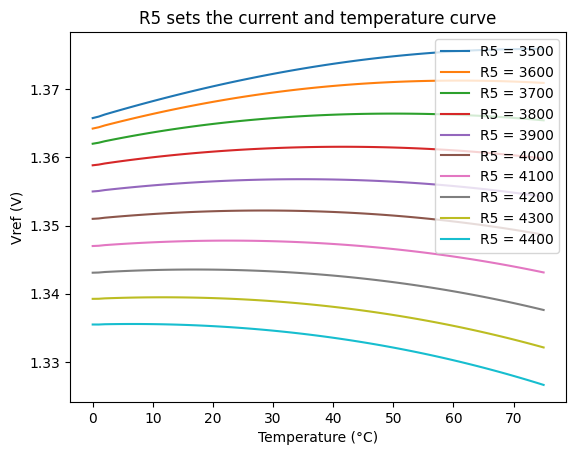

In [21]:
for r5 in range(3500, 4500, 100):
    ng.cmd('alter r5 %d' % r5)
    ng.cmd('dc temp 0 75 1')
    temp = ng.vector('temp-sweep')
    Vout = ng.vector('q8b')
    Ir5 = ng.vector('@r5[i]')
    plt.plot(temp, Vout, label=f'R5 = {r5}')
    delta = Vout[-1] - Vout[0]
    print('R5 = %d, Iq = %6.1f uA, Vref@27C = %.3f V, delta = %7.2f mV' % (r5, 1e6*Ir5[27], Vout[27], delta*1e3))
plt.xlabel('Temperature (°C)')
plt.ylabel('Vref (V)')
plt.title('R5 sets the current and temperature curve')
plt.legend(loc='upper right')

Looks like $R_5=3850$ might be the best candidate for now.

R5 = 3850, Vref@27C = 1.359 V, max-min = 2.190 mV


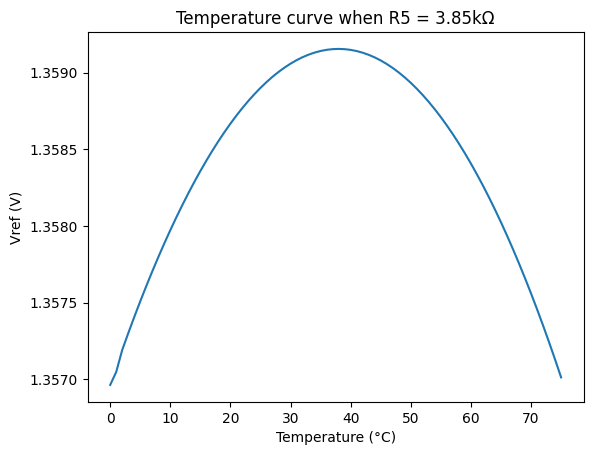

In [24]:
r5 = 3850
ng.cmd('alter r5 %d' % r5)
ng.cmd('dc temp 0 75 1')
temp = ng.vector('temp-sweep')
Vout = ng.vector('q8b')
plt.plot(temp, Vout)
plt.xlabel('Temperature (°C)')
plt.ylabel('Vref (V)')
plt.title('Temperature curve when R5 = 3.85kΩ')
delta = max(Vout) - min(Vout)
print('R5 = %d, Vref@27C = %.3f V, max-min = %.3f mV' % (r5, Vout[27], delta*1e3))

Caveat: quote Bob Pease "The Design of Band-Gap Reference Circuits: Trials and Tribulations" 

> However, there are many ways to get false results in SPICE and other simulation schemes. Most transistor models do not accurately model the shape of the curve of Vbe vs. temperature.
https://www.tayloredge.com/reference/Ganssle-Pease/bobpease-bandgap.pdf


## Error amplifier and output

$R_5$ decides the reference voltage, by setting bias current of bandgap reference, which also sets the tempco curve.

$R_6$ decides the output voltage.

In other words, tempco and Vout can be tuned independently, which made our lives much easier.

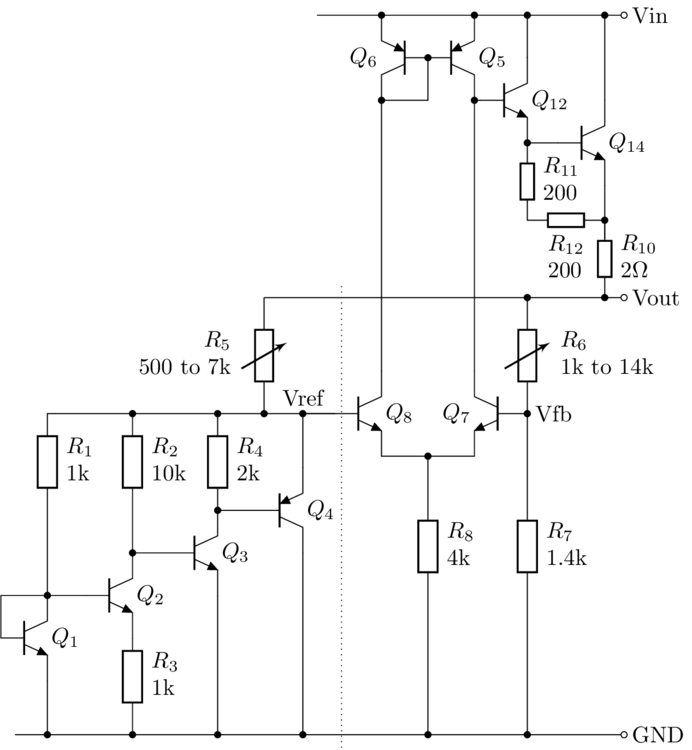

SPICE netlist for DC path of μA78L05.

```SPICE
* DC path of μA78L05
  V1 vcc 0 10V

  * Bandgap reference
  R5 out q8b 4k
  R1 q8b q1b 1k
  R2 q8b q3b 10k
  Q1 q1b q1b 0 NPN
  Q2 q3b q1b r3 NPN
  R3 r3 0 1k
  R4 q8b q4b 2k
  Q3 q4b q3b 0 NPN
  Q4 0 q4b q8b PNP

  * Error amplifier
  Q5 q5c q6b vcc PNP
  Q6 q6b q6b vcc PNP
  Q8 q6b q8b q8e NPN
  R8 q8e 0 4k
  Q7 q5c q7b q8e NPN
  R6 out q7b 3.8k
  R7 q7b 0 1.4k

  * Output
  Q12 vcc q5c q14b NPN
  Q14 vcc q14b q14e NPN 10
  R10 q14e out 2
  R11 q14b q13b 200
  R12 q13b q14e 200

  Rload out 0 1k

  .model NPN NPN(BF=120 Cje=1p Cjc=2p Rb=40 VAF=80 VAR=50 KF=3.2e-16 AF=1)
  .model PNP PNP(BF=60 Cje=1p Cjc=3p Rb=80 VAF=70 VAR=40)
  .options savecurrents
```

In [12]:
ng.circ('''
  V1 vcc 0 10V

  * Bandgap reference
  R5 out q8b 4k
  R1 q8b q1b 1k
  R2 q8b q3b 10k
  Q1 q1b q1b 0 NPN
  Q2 q3b q1b r3 NPN
  R3 r3 0 1k
  R4 q8b q4b 2k
  Q3 q4b q3b 0 NPN
  Q4 0 q4b q8b PNP

  * Error amplifier
  Q5 q5c q6b vcc PNP
  Q6 q6b q6b vcc PNP
  Q8 q6b q8b q8e NPN
  R8 q8e 0 4k
  Q7 q5c q7b q8e NPN
  R6 out q7b 3.8k
  R7 q7b 0 1.4k

  * Output
  Q12 vcc q5c q14b NPN
  Q14 vcc q14b q14e NPN 10
  R10 q14e out 2
  R11 q14b q13b 200
  R12 q13b q14e 200

  Rload out 0 1k
  .model NPN NPN(BF=120 Cje=1p Cjc=2p Rb=40 VAF=80 VAR=50 KF=3.2e-16 AF=1)
  .model PNP PNP(BF=60 Cje=1p Cjc=3p Rb=80 VAF=70 VAR=40)
  .options savecurrents
''')

print_op(False)

  @q12[ic] =  1912.59 uA
  @q14[ic] =  4961.32 uA
   @q1[ic] =   586.14 uA
   @q2[ic] =    59.06 uA
   @q3[ic] =   261.01 uA
   @q4[ic] =    -0.06 uA
   @q5[ic] =   -87.81 uA
   @q6[ic] =   -84.47 uA
   @q7[ic] =    72.30 uA
   @q8[ic] =    87.34 uA
   @r10[i] =  6889.43 uA
   @r11[i] =  1888.26 uA
   @r12[i] =  1888.26 uA
    @r1[i] =   591.60 uA
    @r2[i] =    61.27 uA
    @r3[i] =    59.56 uA
    @r4[i] =   261.01 uA
    @r5[i] =   914.60 uA
    @r6[i] =   963.81 uA
    @r7[i] =   963.24 uA
    @r8[i] =   160.88 uA
 @rload[i] =  5011.02 uA
       out =  5011.02 mV
      q13b =  5402.45 mV
      q14b =  5780.10 mV
      q14e =  5024.80 mV
       q1b =   761.01 mV
       q3b =   739.93 mV
       q4b =   830.60 mV
       q5c =  6571.03 mV
       q6b =  9289.11 mV
       q7b =  1348.53 mV
       q8b =  1352.61 mV
       q8e =   643.52 mV
        r3 =    59.56 mV
 v1#branch = -7049.07 uA
       vcc = 10000.00 mV


## Tune tempco?

TODO: write this part

First, read quote from Bob Pease above.

At any rate, we found the best combination is
$R_5 = 3.92$kΩ, $R_6=3.82$kΩ.

R5 = 3800, Vout@27C = 5.075 V, delta =  15.57 mV
R5 = 3820, Vout@27C = 5.071 V, delta =  13.03 mV
R5 = 3840, Vout@27C = 5.067 V, delta =  10.66 mV
R5 = 3860, Vout@27C = 5.063 V, delta =   8.46 mV
R5 = 3880, Vout@27C = 5.059 V, delta =   6.39 mV
R5 = 3900, Vout@27C = 5.055 V, delta =   4.44 mV
R5 = 3920, Vout@27C = 5.051 V, delta =   2.56 mV
R5 = 3940, Vout@27C = 5.047 V, delta =   0.75 mV
R5 = 3960, Vout@27C = 5.043 V, delta =  -1.03 mV
R5 = 3980, Vout@27C = 5.039 V, delta =  -2.79 mV
R5 = 4000, Vout@27C = 5.035 V, delta =  -4.54 mV
R5 = 4020, Vout@27C = 5.030 V, delta =  -6.30 mV
R5 = 4040, Vout@27C = 5.026 V, delta =  -8.07 mV
R5 = 4060, Vout@27C = 5.022 V, delta =  -9.85 mV
R5 = 4080, Vout@27C = 5.018 V, delta = -11.65 mV


[]

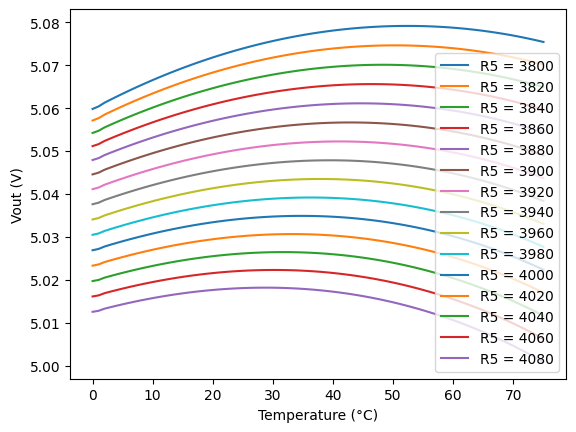

In [17]:
for r5 in range(3800, 4100, 20):
    ng.cmd('alter r5 %d' % r5)
    ng.cmd('dc temp 0 75 1')
    temp = ng.vector('temp-sweep')
    Vout = ng.vector('out')
    plt.plot(temp, Vout, label='R5 = %d' % r5)
    delta = Vout[-1] - Vout[0]
    print('R5 = %d, Vout@27C = %.3f V, delta = %6.2f mV' % (r5, Vout[27], delta*1e3))
plt.xlabel('Temperature (°C)')
plt.ylabel('Vout (V)')
plt.legend()
ng.cmd('alter r5 3920')

## Final version

After setting $R_5 = 3.92$kΩ to get the best tempco from simulation, we fine tune the output voltage to 5.05V, which is 1% higher than 5V.

This gives us $R_6 = 3.82$kΩ.

```SPICE
  * DC path of μA78L05
  V1 vcc 0 10V

  * Bandgap reference
  R5 out q8b 3.92k
  R1 q8b q1b 1k
  R2 q8b q3b 10k
  Q1 q1b q1b 0 NPN
  Q2 q3b q1b r3 NPN
  R3 r3 0 1k
  R4 q8b q4b 2k
  Q3 q4b q3b 0 NPN
  Q4 0 q4b q8b PNP

  * Error amplifier
  Q5 q5c q6b vcc PNP
  Q6 q6b q6b vcc PNP
  Q8 q6b q8b q8e NPN
  R8 q8e 0 4k
  Q7 q5c q7b q8e NPN
  R6 out q7b 3.82k
  R7 q7b 0 1.4k

  * Output
  Q12 vcc q5c q14b NPN
  Q14 vcc q14b q14e NPN 10
  R10 q14e out 2
  R11 q14b q13b 200
  R12 q13b q14e 200

  Rload out 0 1k

  .model NPN NPN(BF=120 Cje=1p Cjc=2p Rb=40 VAF=80 VAR=50 KF=3.2e-16 AF=1)
  .model PNP PNP(BF=60 Cje=1p Cjc=3p Rb=80 VAF=70 VAR=40)
  .options savecurrents
```

In [21]:
ng.circ('''
  V1 vcc 0 10V

  * Bandgap reference
  R5 out q8b 3.92k
  R1 q8b q1b 1k
  R2 q8b q3b 10k
  Q1 q1b q1b 0 NPN
  Q2 q3b q1b r3 NPN
  R3 r3 0 1k
  R4 q8b q4b 2k
  Q3 q4b q3b 0 NPN
  Q4 0 q4b q8b PNP

  * Error amplifier
  Q5 q5c q6b vcc PNP
  Q6 q6b q6b vcc PNP
  Q8 q6b q8b q8e NPN
  R8 q8e 0 4k
  Q7 q5c q7b q8e NPN
  R6 out q7b 3.82k
  R7 q7b 0 1.4k

  * Output
  Q12 vcc q5c q14b NPN
  Q14 vcc q14b q14e NPN 10
  R10 q14e out 2
  R11 q14b q13b 200
  R12 q13b q14e 200

  Rload out 0 1k
  .model NPN NPN(BF=120 Cje=1p Cjc=2p Rb=40 VAF=80 VAR=50 KF=3.2e-16 AF=1)
  .model PNP PNP(BF=60 Cje=1p Cjc=3p Rb=80 VAF=70 VAR=40)
  .options savecurrents
''')

print_op(False)

  @q12[ic] =  1914.09 uA
  @q14[ic] =  5031.07 uA
   @q1[ic] =   591.38 uA
   @q2[ic] =    59.22 uA
   @q3[ic] =   282.56 uA
   @q4[ic] =    -0.31 uA
   @q5[ic] =   -88.46 uA
   @q6[ic] =   -85.14 uA
   @q7[ic] =    72.92 uA
   @q8[ic] =    88.03 uA
   @r10[i] =  6960.69 uA
   @r11[i] =  1889.20 uA
   @r12[i] =  1889.20 uA
    @r1[i] =   596.88 uA
    @r2[i] =    61.61 uA
    @r3[i] =    59.72 uA
    @r4[i] =   282.55 uA
    @r5[i] =   942.03 uA
    @r6[i] =   967.76 uA
    @r7[i] =   967.18 uA
    @r8[i] =   162.21 uA
 @rload[i] =  5050.90 uA
       out =  5050.90 mV
      q13b =  5442.66 mV
      q14b =  5820.50 mV
      q14e =  5064.82 mV
       q1b =   761.24 mV
       q3b =   742.01 mV
       q4b =   793.02 mV
       q5c =  6611.47 mV
       q6b =  9288.91 mV
       q7b =  1354.06 mV
       q8b =  1358.12 mV
       q8e =   648.83 mV
        r3 =    59.72 mV
 v1#branch = -7121.65 uA
       vcc = 10000.00 mV


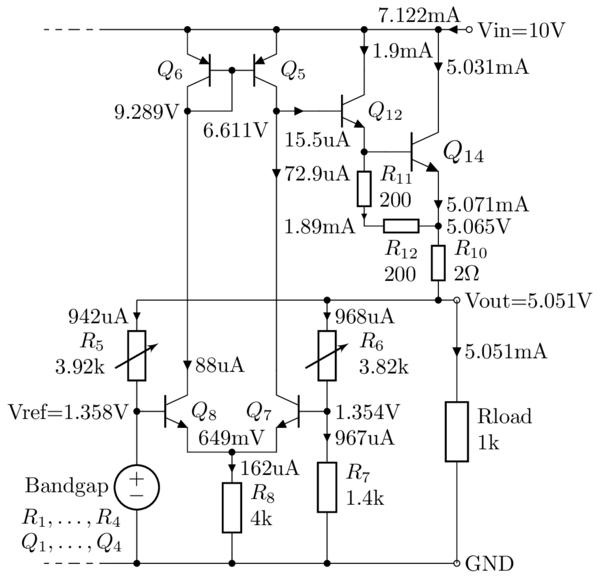

Temperature curve:

R5 = 3920, Vout@27C = 5.051 V, max-min = 11.102 mV


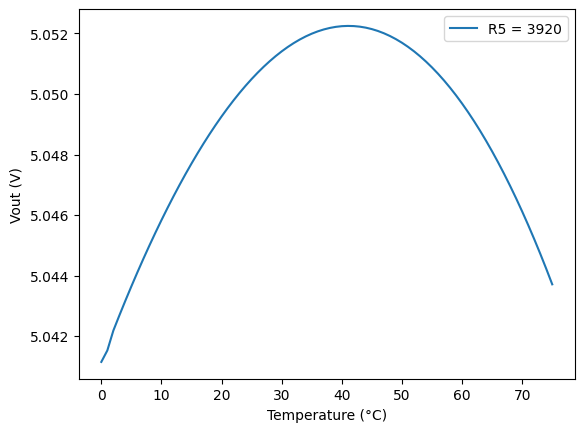

In [20]:
r5 = 3920
ng.cmd('dc temp 0 75 1')
temp = ng.vector('temp-sweep')
Vout = ng.vector('out')
plt.plot(temp, Vout, label='R5 = %d' % r5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Vout (V)')
plt.legend()
delta = max(Vout) - min(Vout)
print('R5 = %d, Vout@27C = %.3f V, max-min = %.3f mV' % (r5, Vout[27], delta*1e3))

## Line Regulation

Sweeping Vin from 7V to 20V, observing Vout.

```
.dc v1 7 20 0.1
```

Datasheet says the typical $\Delta V_\mathrm{out}$ is 32mV.

Our SPICE model is worse than that spec.

Delta Vout = 43.32 mV


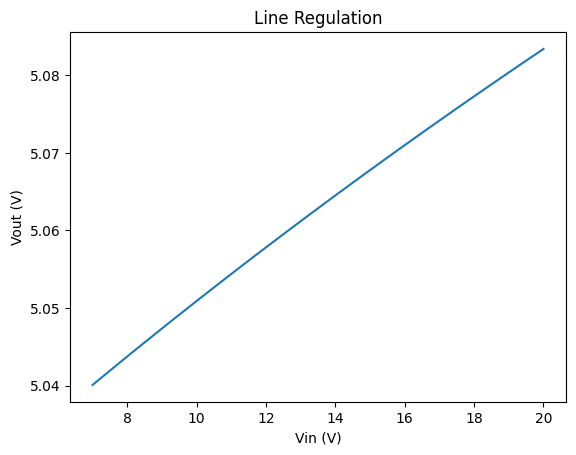

In [6]:
ng.cmd('dc v1 7 20 0.1')
Vout = ng.vector('out')
plt.plot(ng.vector('v-sweep'), Vout)
plt.xlabel('Vin (V)')
plt.ylabel('Vout (V)')
plt.title('Line Regulation')
delta = Vout[-1] - Vout[0]
print('Delta Vout = %.2f mV' % (1e3 * delta))

TODO: find a way to fix line regulation ratio.

## Load Regulation

Sweeping Rload from 50Ω to 5000Ω, Iout changes from 100mA to 1mA.

```
.dc rload 50 5000 1
```

Datasheet says the typical $\Delta V_\mathrm{out}$ is 15mV.

Our SPICE model matches that spec.

Delta Vout = 14.52 mV


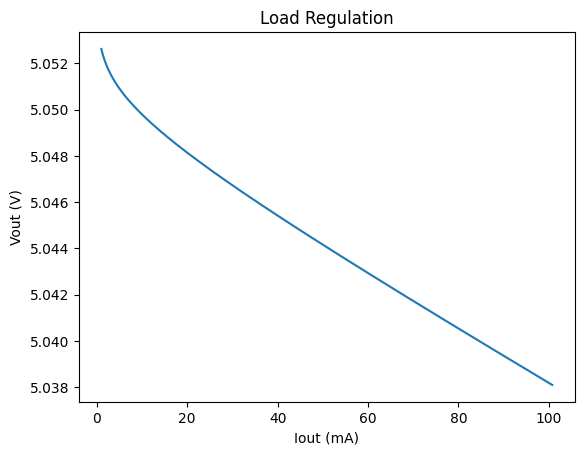

In [10]:
ng.cmd('dc rload 50 5000 1')
Vout = ng.vector('out')
Iout = Vout / ng.vector('res-sweep')
plt.plot(Iout * 1e3, Vout)
plt.xlabel('Iout (mA)')
plt.ylabel('Vout (V)')
plt.title('Load Regulation')
delta = Vout[-1] - Vout[0]
print('Delta Vout = %.2f mV' % (1e3 * delta))

## Dropout voltage

Sweeping Vin from 3V to 8V, observing Vout.

```
.dc v1 3 8 0.1
```

The simulated dropout is ~1.7V, mainly due to Vbe of $Q_{12}$ and $Q_{14}$.
This matches datasheet.

Vin = 6.00 V, Vout = 4.42 V, Dropout = 1.58 V
Vin = 6.10 V, Vout = 4.52 V, Dropout = 1.58 V
Vin = 6.20 V, Vout = 4.62 V, Dropout = 1.58 V
Vin = 6.30 V, Vout = 4.72 V, Dropout = 1.58 V
Vin = 6.40 V, Vout = 4.81 V, Dropout = 1.59 V
Vin = 6.50 V, Vout = 4.90 V, Dropout = 1.60 V
Vin = 6.60 V, Vout = 4.98 V, Dropout = 1.62 V
Vin = 6.70 V, Vout = 5.03 V, Dropout = 1.67 V
Vin = 6.80 V, Vout = 5.04 V, Dropout = 1.76 V
Vin = 6.90 V, Vout = 5.04 V, Dropout = 1.86 V
Vin = 7.00 V, Vout = 5.04 V, Dropout = 1.96 V


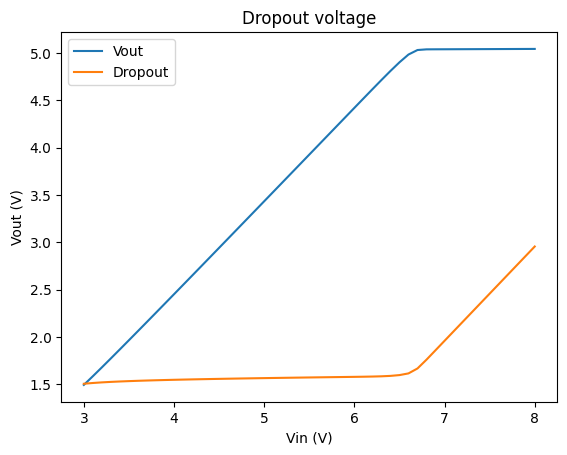

In [32]:
ng.cmd('dc v1 3 8 0.1')
Vin = ng.vector('v-sweep')
Vout = ng.vector('out')
plt.plot(Vin, Vout, label='Vout')
plt.plot(Vin, Vin-Vout, label='Dropout')
plt.xlabel('Vin (V)')
plt.ylabel('Vout (V)')
plt.title('Dropout voltage')
plt.legend()
for i in range(30, 41):
    print('Vin = %.2f V, Vout = %.2f V, Dropout = %.2f V' % (Vin[i], Vout[i], Vin[i] - Vout[i]))

Due to the lack of start-up circuit in our model, the Vin can't be swept from 0V upwards.

## Loose end

We simulated the DC path of μA78L05 using NgSpice.

We didn't model the start-up circuit, or any protection circuits (overheat, current limiting), nor any AC characteristics (transient, frequency response, ripple rejection, etc.).

So the SPICE model presented here is not a practical model for simulating μA78L05 in real life, but a tool to study how it works. Especially how its feedback loop worked.